# TPS-Feb-2022

In [1]:
NB = '102'
dataset_NB = '001'

## Import libralies

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import time

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping


## Load and check data

In [3]:
# Load data
##### Load train and Test set
train = pd.read_pickle(f"../data/processed/nb{dataset_NB}_train.pkl", compression='zip')
test = pd.read_pickle(f"../data/processed/nb{dataset_NB}_test.pkl", compression='zip')

submission = pd.read_csv('../data/raw/sample_submission.csv')

In [4]:
train_len = len(train)
test_id = test['row_id']

#dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
# reset_index: indexを0から順に振り直す
# drop: Falseの場合、元のindexが「index」列が新たに生成されて残る。Trueの場合「index」列は作られない。

#dataset = dataset.drop(columns=['row_id'])
#train = train.drop(columns=['row_id'])

#dataset.head()

## Parameter Setting

In [5]:
RANDOM_STATE = 13
FOLDS = 2
TARGET = 'target'
FEATURES = [col for col in train.columns if col not in ['row_id', TARGET]]

## Modeling

### 目的変数（target）を数値に変換する

In [6]:
encoder = LabelEncoder()
train[TARGET] = encoder.fit_transform(train[TARGET])

In [7]:
train.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target,mean,std,min,max
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,9,2.767028e-17,0.005643,-0.014033,0.023992
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,6,1.129996e-17,0.001751,-0.005016,0.008984
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000072,0.000010,0.000008,0.000019,1.046326e-06,6,-1.785171e-18,0.000601,-0.002587,0.002327
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,6,-4.829865e-19,0.001160,-0.005403,0.004602
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,2,2.872491e-17,0.007117,-0.024033,0.037984


### LightGBM

In [13]:
lgb_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    "n_estimators": 3000,
}

# LightGBM parameters
lgb_param_grid = {
                 "learning_rate": [0.1, 0.05],
                 #'num_leaves' : [15, 31, 63],
                 #'max_depth'  : [9, 15, 21],
                 'num_leaves' : [12, 15, 18],
                 'max_depth'  : [6, 9, 15],
                 #'min_gain_to_split' : [0, 0.1, 0.2],
                 'feature_fraction' : [0.5, 0.7, 1],
                 #'bagging_fraction' : [0.7, 0.9, 1],
                 #'min_sum_hessian_in_leaf' : [1, 2, 4],
                }

callbacks = [early_stopping(100)]

In [14]:
lgb_predictions = []
lgb_scores = []
lgb_feature_importance = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(skf.split(train[FEATURES], train[TARGET])):

    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()

    ### データセット作成
    X_train, X_val = train.iloc[train_idx][FEATURES], train.iloc[val_idx][FEATURES]
    y_train, y_val = train[TARGET].iloc[train_idx] , train[TARGET].iloc[val_idx]

    ### 学習
    model = LGBMClassifier(**lgb_params)

    #model.fit(X_train, y_train,verbose=0)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0, callbacks=callbacks)

    #gs_model = GridSearchCV(model, param_grid=lgb_param_grid, scoring=accuracy_score, cv=kfold, n_jobs=-1, verbose=1)
    #gs_mode.fit(x_train, y_train)

    ### 推論（validation）
    preds_val = model.predict(X_val)
    acc = accuracy_score(y_val, preds_val)
    lgb_scores.append(acc)

    ### feature importance
    feat_imp = pd.DataFrame(index=FEATURES, data=model.feature_importances_, columns=[f'{fold}_importance'])
    lgb_feature_importance.append(feat_imp)

    ### 推論（test）
    test_preds = model.predict(test[FEATURES])
    lgb_predictions.append(test_preds)

    ### 結果表示
    run_time = time.time() - start_time
    print(f"Fold={fold+1}, Accuracy: {acc:.5f}, Run Time: {run_time:.2f}s")

print("Mean Accuracy :", np.mean(lgb_scores))

========== Fold=1 ==========
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[542]	valid_0's multi_logloss: 0.0335412
Fold=1, Accuracy: 0.98862, Run Time: 493.11s
========== Fold=2 ==========
Early stopping, best iteration is:
[542]	valid_0's multi_logloss: 0.0335412
Fold=2, Accuracy: 0.98843, Run Time: 463.76s
Mean Accuracy : 0.9885250000000001


### feature importances

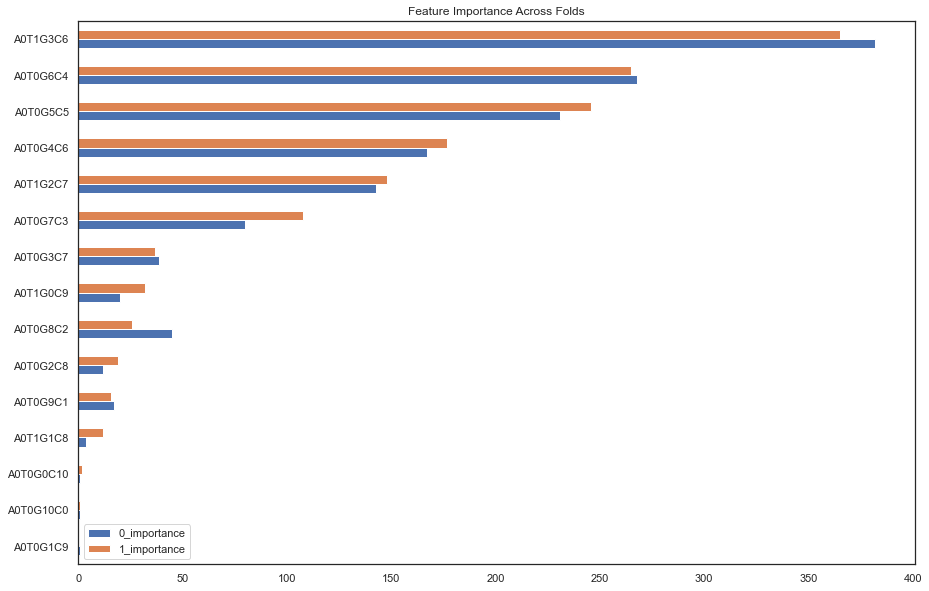

In [15]:
lgbm_fis_df = pd.concat(lgb_feature_importance, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10), title='Feature Importance Across Folds')
plt.show()

## Submission

In [16]:
lgb_submission = submission.copy()
lgb_submission[TARGET] = encoder.inverse_transform(np.squeeze(mode(np.column_stack(lgb_predictions),axis = 1)[0]).astype('int'))
### 列方向にリストを行列化して、各行の最頻値をとって、１次元の配列は削除して、intにして、数値をラベルに戻している

lgb_submission.to_csv(f"../data/submission/nb{NB}_LGBM.csv",index=False)
lgb_submission.head()

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus


## 検証メモ